This notebook performs the following steps.

* Test any saved method on the dataset you choosed.
* claculate the general
* For the Eyeball dataset store the ground truth and predictions in an excel file and store the images in an ordered manner so that you can go over them one by one and do a detailed error analysis.

# Load the models

In [1]:
import torch
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")


# HOARDING 4-fold CV
model_dirs = ['../../results/saved_models_pytorch/resnet18__sgd_0.0xsingle + 1.0Xmulti_May31  09:51:13_last',
             '../../results/saved_models_pytorch/resnet18__sgd_0.0xsingle + 1.0Xmulti_May31  09:56:21_last',
             '../../results/saved_models_pytorch/resnet18__sgd_0.0xsingle + 1.0Xmulti_May31  10:01:36_last',
             '../../results/saved_models_pytorch/resnet18__sgd_0.0xsingle + 1.0Xmulti_May31  10:06:47_last']


'''
#AMAZON
model_dirs = ['../../results/saved_models_pytorch/resnet18__sgd_0.0xsingle + 1.0Xmulti_May17  16:31:22_last',
             '../../results/saved_models_pytorch/resnet18__sgd_0.0xsingle + 1.0Xmulti_May17  20:07:05_last',
             '../../results/saved_models_pytorch/resnet18__sgd_0.0xsingle + 1.0Xmulti_May17  23:43:21_last',
             '../../results/saved_models_pytorch/resnet18__sgd_0.0xsingle + 1.0Xmulti_May18  03:20:32_last',
             '../../results/saved_models_pytorch/resnet18__sgd_0.0xsingle + 1.0Xmulti_May18  06:57:13_last']
'''
'''
#HOARDING
model_dirs = ['../../results/saved_models_pytorch/resnet18__sgd_0.0xsingle + 1.0Xmulti_May23  17:17:44_last',
             '../../results/saved_models_pytorch/resnet18__sgd_0.0xsingle + 1.0Xmulti_May23  22:07:02_last',
             '../../results/saved_models_pytorch/resnet18__sgd_0.0xsingle + 1.0Xmulti_May23  21:17:23_last',
             '../../results/saved_models_pytorch/resnet18__sgd_0.0xsingle + 1.0Xmulti_May23  22:23:25_last']
'''

'''
model_dirs = ['../../results/saved_models_pytorch/resnet18__sgd_0.0xsingle + 1.0Xmulti_May29  02:23:45_last',
             '../../results/saved_models_pytorch/resnet18__sgd_0.0xsingle + 1.0Xmulti_May29  09:40:05_last',
             '../../results/saved_models_pytorch/resnet18__sgd_0.0xsingle + 1.0Xmulti_May29  13:21:40_last',
             '../../results/saved_models_pytorch/resnet18__sgd_0.0xsingle + 1.0Xmulti_May28  22:45:42_last']
'''


#model_names = ['ccr', 'ccr1', 'mae', 'rmse', 'cheng']
model_names = [''1', '2', '3', '4'']

models = [torch.load(model_dir).to(device) for model_dir in model_dirs]

for model in models:
    model.train(False)
    
'''models = {model_name: torch.load(model_dir).to(device) 
          for model_name, model_dir in zip(model_names, model_dirs)}
for _, model in models.items():
    model.train(False)
'''
    
if use_gpu:
    print('GPU is available')
else:
    print('!!!!! NO CUDA GPUS DETECTED')

GPU is available


# Load the Data

In [2]:
from torchvision import datasets, transforms
import numpy as np

random_seed = 1
CV = 4
batch_size=32

data_transforms =transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
data_dir = '../../datasets/hoarding/images'


if CV == 0:
    dset = datasets.ImageFolder(data_dir, data_transforms)

    '''Define dataset loader'''
    dset_loader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=False, num_workers=12)
    dset_classes = dset.classes

else:
    dset = datasets.ImageFolder(data_dir+'/train_val', data_transforms)
    num_train = len(dset)
    indices = list(range(num_train))
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    splits = (num_train*np.linspace(0,1,CV+1)).astype(int)
    val_idx = [indices[splits[k]:splits[k+1]] for k in range(CV)]

    '''Sampler functions for validation and training'''
    sampler = [torch.utils.data.sampler.SubsetRandomSampler(val_idx[k]) for k in range(CV)]

    '''Define dataset loaders'''
    dset_loader_arr = [torch.utils.data.DataLoader(dset, batch_size=batch_size,sampler=sampler[k],
                                                   num_workers=12) for k in range(CV)]
    dset_classes = dset.classes

Size of the input tensors in one batch after grid is  torch.Size([3, 906, 1810])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


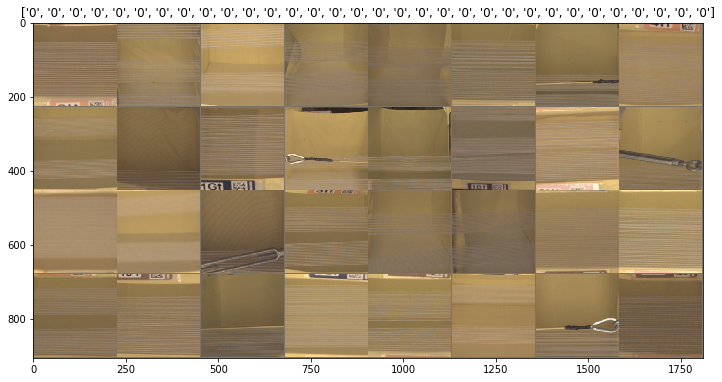

In [8]:
# Check the first images

import sys
sys.path.append("..")

import torchvision
from matplotlib import pyplot as plt
%matplotlib inline
from functions import fine_tune as ft

inputs, classes = next(iter(dset_loader))
out = torchvision.utils.make_grid(inputs,nrow=8)
print('Size of the input tensors in one batch after grid is  '+str(out.size()))
plt.figure(figsize=(12,12))
ft.imshow(out, title=[dset_classes[x] for x in classes])

# Statistics and Creating an Error Analysis File

In [9]:
def softmax(inp, tau = 1):
    out = np.exp(inp/tau)
    out = out / np.sum(out, axis=1).reshape(-1,1)
    return out

def ccr1_prob(inp):
    ccr1_arr = np.eye(inp.shape[1])
    for k in range(inp.shape[1]-1):
        ccr1_arr[k,k+1] = 1
        ccr1_arr[k+1,k] = 1
    
    #ccr1_arr = ccr1_arr / np.sum(ccr1_arr, axis=1).reshape(-1,1)
    #print(ccr1_arr)
    return inp @ ccr1_arr

In [8]:
import numpy as np
from torch.autograd import Variable
from datetime import datetime
import os

save_imgs = False
name = 'ccr1'

if save_imgs:
    date_now = str(datetime.now())
    os.makedirs('../../results/eyeball_logs/images/' +str(date_now))
    img_count = 0
    
preds = np.zeros((0,1))
labels = np.zeros((0,1))
dset_loader = dset_loader_arr[2]
model = models[2]

for model, dset_loader in zip(models, dset_loader_arr):
    for data in dset_loader:
        # get the inputs
        inputs, label = data
        inputs, label = inputs.to(device), label.to(device)
        labels = np.append(labels, label.data.to('cpu').numpy().reshape(-1, 1), axis=0)

        imgs = inputs.data.to('cpu').numpy()
        #print(inputs.data.to('cpu').shape)
        if save_imgs:
            for k in range(imgs.shape[0]):
                img = imgs[k,:,:,:].transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                plt.imsave('../../results/eyeball_logs/images/' + str(date_now) + '/' +
                           str(img_count) + '.png', img)
                img_count += 1
        #for name, model in models.items():

        #for name, model in models.items():


        outputs = model(inputs)
        if name is 'cheng':
            pred = (outputs.data.to('cpu').numpy() > 0.0).astype(np.int)
            pred = (np.sum(np.cumprod(pred, axis=1), axis=1) - 1).reshape(-1, 1)
        else:
            #prob_np = softmax(outputs.data.to('cpu').numpy())
            #prob_ccr1 = ccr1_prob(prob_np)
            #cdf = np.cumsum(prob_np, axis=1)
            #pred = np.sum((cdf <= .5).astype(np.int), axis=1).reshape(-1,1)

            #pred = np.round(prob_np @ np.arange(10).reshape(-1,1))
            pred = np.argmax(outputs.data.to('cpu').numpy(), axis=1).reshape(-1, 1)

        preds = np.append(preds, pred, axis = 0)


        # result_log.append((phase, epoch, labels.data.cpu().numpy(), outputs.data.cpu().numpy()))


err = np.abs(preds-labels)
print(np.mean(err==0), np.mean(err<=1), np.mean(err), np.sqrt(np.mean(err**2)))

0.3381995133819951 0.8142741281427412 0.943227899432279 1.332420612176743


In [19]:
import numpy as np
from torch.autograd import Variable
from datetime import datetime
import os

save_imgs = False
name = 'ccr1'

if save_imgs:
    date_now = str(datetime.now())
    os.makedirs('../../results/eyeball_logs/images/' +str(date_now))
    img_count = 0
    
#preds = {name: np.zeros((0,1)) for name in models}
preds = {'ccr1': np.zeros((0,1))}
labels = np.zeros((0,1))

for model, dset_loader in zip(models, dset_loader_arr):
    for data in dset_loader:
        # get the inputs
        inputs, label = data
        inputs, label = inputs.to(device), label.to(device)
        labels = np.append(labels, label.data.to('cpu').numpy().reshape(-1, 1), axis=0)

        imgs = inputs.data.to('cpu').numpy()
        #print(inputs.data.to('cpu').shape)
        if save_imgs:
            for k in range(imgs.shape[0]):
                img = imgs[k,:,:,:].transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                plt.imsave('../../results/eyeball_logs/images/' + str(date_now) + '/' +
                           str(img_count) + '.png', img)
                img_count += 1
        #for name, model in models.items():

        #for name, model in models.items():
        
        
        outputs = model(inputs)
        if name is 'cheng':
            pred = (outputs.data.to('cpu').numpy() > 0.0).astype(np.int)
            pred = (np.sum(np.cumprod(pred, axis=1), axis=1) - 1).reshape(-1, 1)
        else:
            prob_np = softmax(outputs.data.to('cpu').numpy())
            prob_ccr1 = ccr1_prob(prob_np)
            #cdf = np.cumsum(prob_np, axis=1)
            #pred = np.sum((cdf <= .5).astype(np.int), axis=1).reshape(-1,1)

            #pred = np.round(prob_np @ np.arange(10).reshape(-1,1))
            pred = np.argmax(prob_ccr1, axis=1).reshape(-1, 1)

        preds[name] = np.append(preds[name], pred, axis = 0)
        
        
        # result_log.append((phase, epoch, labels.data.cpu().numpy(), outputs.data.cpu().numpy()))

    
errors = {name: preds[name]- labels for name in models}
metrics = {'CCR': [np.mean(errors[name]==0) for name in models],
          'CCR-1': [np.mean(np.abs(errors[name])<=1) for name in models],
          'MAE': [np.mean(np.abs(errors[name])) for name in models],
          'RMSE': [np.sqrt(np.mean(errors[name]**2)) for name in models]}

print('Loss functions are ' + str(model_names))
for name, metric in metrics.items():
    print(name + ' results are ' + str(np.round(metrics[name], decimals=3)))


KeyError: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer3): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (avgpool): AvgPool2d(kernel_size=7, stride=1, padding=0)
  (fc): Linear(in_features=512, out_features=9, bias=True)
)

In [22]:
err = np.abs(preds['ccr1'] - labels)
print(np.mean(err==0))

0.3519870235198702


In [19]:
'''
CHENGS+ METHOD 

Calculate PMF for CDF and take the argmax
''' 


import numpy as np
from torch.autograd import Variable
from datetime import datetime
import os


cdf2pmf = np.eye(10)
for k in range(9):
    cdf2pmf[k+1, k] = -1
    
save_imgs = False

if save_imgs:
    date_now = str(datetime.now())
    os.makedirs('../../results/eyeball_logs/images/' +str(date_now))
    img_count = 0
    
preds = {name: np.zeros((0,1)) for name in models}
labels = np.zeros((0,1))

for data in dset_loader:
    # get the inputs
    inputs, label = data
    inputs, label = inputs.to(device), label.to(device)
    labels = np.append(labels, label.data.to('cpu').numpy().reshape(-1, 1), axis=0)
    
    imgs = inputs.data.to('cpu').numpy()
    #print(inputs.data.to('cpu').shape)
    if save_imgs:
        for k in range(imgs.shape[0]):
            img = imgs[k,:,:,:].transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            plt.imsave('../../results/eyeball_logs/images/' + str(date_now) + '/' +
                       str(img_count) + '.png', img)
            img_count += 1
    #for name, model in models.items():
    
    for name, model in models.items():
        outputs = model(inputs)
        if True: #name is 'cheng':
            out = outputs.data.to('cpu').numpy()
            #print('CDF is ' + str(out[5,:]))
            out = 1/(1+np.exp(-out))
            prob = out @ cdf2pmf
            #print('PMF is ' + str(prob[5,:]))
            pred = np.argmax(prob, axis=1).reshape(-1, 1)
            #print(pred.shape)
        else:
            _, pred = torch.max(outputs.data, 1)
            pred = pred.to('cpu').numpy().reshape(-1, 1)
            
        preds[name] = np.append(preds[name], pred, axis = 0)
    # result_log.append((phase, epoch, labels.data.cpu().numpy(), outputs.data.cpu().numpy()))

    
errors = {name: preds[name]- labels for name in models}
metrics = {'CCR': [np.mean(errors[name]==0) for name in models],
          'CCR-1': [np.mean(np.abs(errors[name])<=1) for name in models],
          'MAE': [np.mean(np.abs(errors[name])) for name in models],
          'RMSE': [np.sqrt(np.mean(errors[name]**2)) for name in models]}

print('Loss functions are ' + str(model_names))
for name, metric in metrics.items():
    print(name + ' results are ' + str(np.round(metrics[name], decimals=3)))


Loss functions are ['lambda=0', 'lambda=0.01', 'lambda=0.04', 'lambda=0.1']
CCR results are [0.367 0.361 0.343 0.327]
CCR-1 results are [0.657 0.648 0.618 0.589]
MAE results are [1.337 1.352 1.477 1.604]
RMSE results are [2.015 2.016 2.175 2.338]


In [9]:
'''
!!! NOT NECESARY FOR THE REST OF THE BLOCKS !!!
Try the windowing approach: Start with CCR-1 based loss function 
and choose the best one using CCR based loss function.
'''
preds_wiw = preds['cheng'].copy()
preds_wiw[preds_wiw < preds['ccr1'] - 1] =  preds['ccr1'][preds_wiw < preds['ccr1'] - 1] - 1
preds_wiw[preds_wiw > preds['ccr1'] + 1] =  preds['ccr1'][preds_wiw > preds['ccr1'] + 1] + 1

err_wiw = preds_wiw - labels

ccr_wiw = np.mean(err_wiw == 0)
ccr1_wiw = np.mean(np.abs(err_wiw) <= 1)
mae_wiw = np.mean(np.abs(err_wiw))
rmse_wiw = np.sqrt(np.mean(err_wiw ** 2))

print(ccr_wiw, ccr1_wiw, mae_wiw, rmse_wiw)

out = np.zeros((len(preds_wiw),3))
out[:, 0] = preds['ccr'].reshape(-1)
out[:, 1] = preds['ccr1'].reshape(-1)
out[:, 2] = preds_wiw.reshape(-1)

#np.set_printoptions(threshold=20)
print(out)


0.38 0.644 1.256 1.865475810617763
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 1.]
 [0. 1. 0.]
 [1. 4. 4.]
 [2. 2. 2.]
 [1. 2. 2.]
 [1. 2. 1.]
 [1. 1. 0.]
 [1. 1. 1.]
 [1. 2. 2.]
 [1. 2. 1.]
 [1. 1. 1.]
 [9. 8. 7.]
 [1. 2. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 2. 1.]
 [1. 2. 2.]
 [1. 2. 1.]
 [1. 1. 0.]
 [3. 2. 3.]
 [1. 1. 1.]
 [1. 2. 1.]
 [1. 2. 1.]
 [1. 2. 1.]
 [1. 2. 1.]
 [1. 2. 1.]
 [0. 1. 0.]
 [1. 2. 2.]
 [4. 4. 5.]
 [2. 2. 2.]
 [2. 2. 3.]
 [1. 2. 1.]
 [2. 3. 3.]
 [1. 2. 2.]
 [2. 3. 3.]
 [2. 2. 2.]
 [2. 2. 2.]
 [1. 2. 3.]
 [6. 5. 5.]
 [3. 4. 4.]
 [2. 2. 2.]
 [3. 3. 4.]
 [4. 3. 4.]
 [1. 2. 1.]
 [8. 8. 7.]
 [1. 2. 1.]
 [2. 2. 2.]
 [2. 2. 3.]
 [2. 3. 2.]
 [1. 2. 1.]
 [9. 8. 7.]
 [4. 4. 4.]
 [3. 2. 3.]
 [5. 6. 6.]
 [2. 2. 2.]
 [4. 6. 5.]
 [3. 3. 3.]
 [4. 

In [14]:
'''
Slightly changed for hoarding data, for abi delete +1s and uncomment CHENG
'''

import xlsxwriter

# Create a workbook and add a worksheet.
fname = '../../results/eyeball_logs/logs/' + str(date_now) + '.xlsx'
workbook = xlsxwriter.Workbook(fname)
worksheet = workbook.add_worksheet()

# Iterate over the data and write it out row by row.
worksheet.write(0,0, 'ID')
worksheet.write(0,1, 'GT')
worksheet.write(0,2, 'CCR')
worksheet.write(0,3, 'CCR1')
worksheet.write(0,4, 'MAE')
worksheet.write(0,5, 'MSE')
#worksheet.write(0,6, 'CHENG')
for k in range(len(labels)):
    row = k+1
    worksheet.write(row, 0, k)
    worksheet.write(row, 1, labels[k]+1)
    worksheet.write(row, 2, preds['ccr'][k]+1)
    worksheet.write(row, 3, preds['ccr1'][k]+1)
    worksheet.write(row, 4, preds['mae'][k]+1)
    worksheet.write(row, 5, preds['mse'][k]+1)
    #worksheet.write(row, 6, preds['cheng'][k])


workbook.close()

### Error histograms (Predcition - Ground Truth)

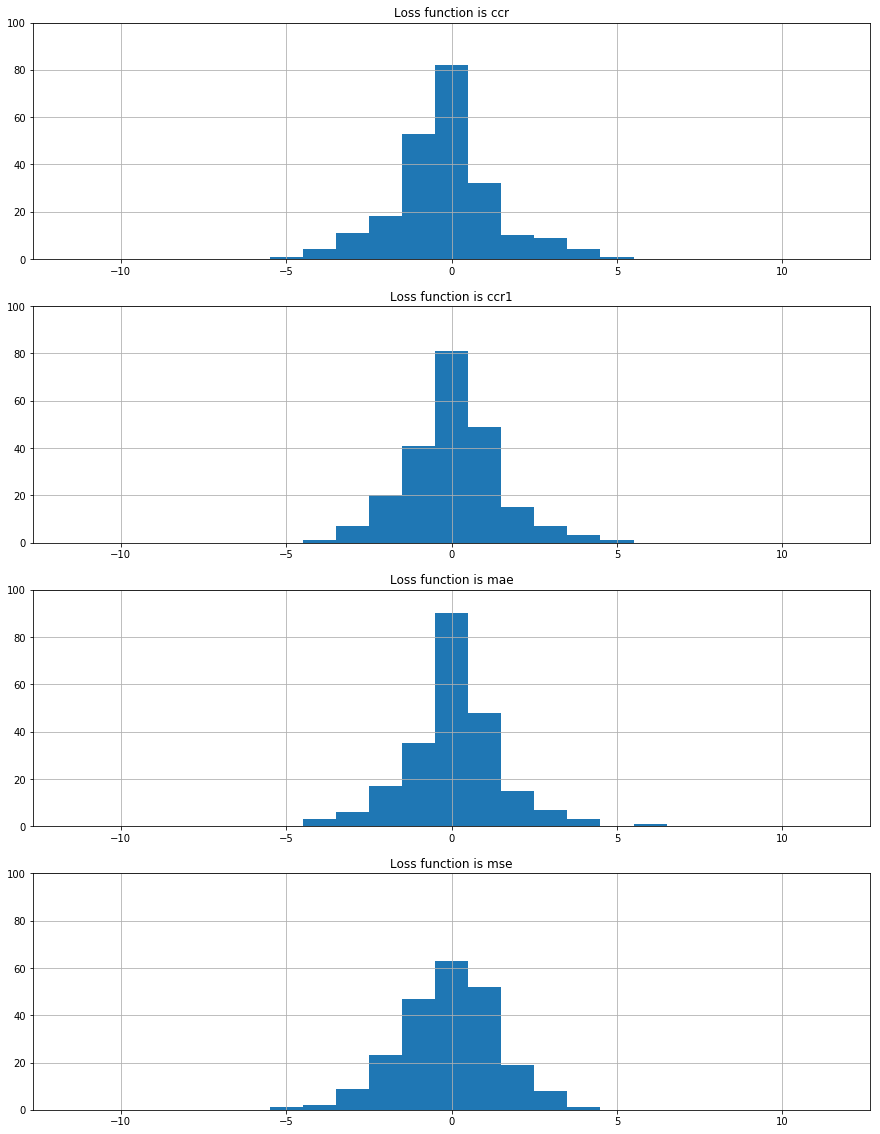

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize = (15,20))
n_plots = len(errors)

k = 1
for name, error in  errors.items():
    plt.subplot(n_plots, 1, k)
    plt.hist(error, bins = [k+0.5 for k in range(-12, 12)])
    plt.title('Loss function is ' + str(name))
    plt.ylim(0,100)
    plt.grid()
    k += 1
    
plt.savefig('../../results/plots/eyeball_histograms.png')
    